### GIADA BARZAGHI - OCTOBER 2021
## MODEL 2: ITINERARIES AND FIXED DEMAND
#### OPTIMIZING AVIATION NETWORKS TO MINIMIZE POLLUTION 

In [1]:
# GIADA BARZAGHI - SEPTEMBER 2021
# MODEL 2: WITH ITINERARIES AND FIXED DEMAND

# SETTING UP WORKING ENVIRONMENT 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyomo.environ import *
import string
import math as math
import random
import itertools
import geopandas # on terminal: conda activate geo_env ---- jupyter notebook if not launching from anaconda navigator 
from shapely.geometry import Point, Polygon
from geopy.distance import great_circle

# PRE PROCESSING

### SETS

In [15]:
# set of aircraft models
A = ['E170', 'A319', 'A321']

In [4]:
# set of flights
F = [('A','B'),('B','C'),('A','C')]

In [5]:
# set of itineraries 
I = [('A','-', 'B'),('B','-','C'),('A','-','C'), ('A', 'B', 'C')]

In [6]:
# set of markets (only considering airport-pairs for now)
M = [('A','B'),('B','C'),('A','C')]

#### subset of flights that make up an itinerary (muted code)
F_i = {}
for i in I:
    X = []
    for f in F:
        if len(i) == 2 and f[0]==i[0] and f[-1]==i[-1]: 
            F_i[i] = f
        elif len(i) != 2:
            if f[0]==i[0] or f[-1]==i[-1]:
                X.append(f)
            F_i[i] = X
print(F_i)
            

### PARAMETERS 

In [7]:
# pollution generated by flying flight f with aircraft a 
# -------> see Seymour 
np.random.seed(1234)
p = {}
for f in F:
    for a in A:
        p[f, a]=np.random.randint(50, 1000)
p

{(('A', 'B'), 'E90'): 865,
 (('A', 'B'), 'A320'): 773,
 (('A', 'B'), 'A321'): 344,
 (('B', 'C'), 'E90'): 103,
 (('B', 'C'), 'A320'): 254,
 (('B', 'C'), 'A321'): 422,
 (('A', 'C'), 'E90'): 714,
 (('A', 'C'), 'A320'): 705,
 (('A', 'C'), 'A321'): 739}

#### Tau (MUTED): dummy for whether flight f can be operated with aircraft type a : ASSIGNING 1 TO ALL OF THEM 
np.random.seed(1234)
tau = {}
for f in F:
    for a in A:
        tau[f, a]=1

tau

In [101]:
# Tau : dummy for whether flight f can be operated with aircraft type a
np.random.seed(1234)
tau = {}
for f in F:
    for a in A:
        if np.random.rand()<=0.5: #(0.5 probability of being yes or no)
            tau[f, a]=1
        else:
            tau[f, a]=0
tau

{(('A', 'B'), 'E90'): 1,
 (('A', 'B'), 'A320'): 0,
 (('A', 'B'), 'A321'): 1,
 (('B', 'C'), 'E90'): 0,
 (('B', 'C'), 'A320'): 0,
 (('B', 'C'), 'A321'): 1,
 (('A', 'C'), 'E90'): 1,
 (('A', 'C'), 'A320'): 0,
 (('A', 'C'), 'A321'): 0}

In [11]:
# number of passengers estimated in the market for each airport pair
np.random.seed(1234)
d = {}
for mkt in M:
    d[mkt]=np.random.randint(100,300)
d

NameError: name 'M' is not defined

In [12]:
# seat capacity -> from Seymour appendix L (ICAO codes)
K = {'E170':74, 'A319': 137, 'A321':194}

In [104]:
# flight activation - randomly assigned with 80% probability of being activated 
Z = {}
for f in F: 
    if np.random.rand()<=0.8:
        Z[f]=1
    else:
        Z[f]=0
print(Z)

{('A', 'B'): 1, ('B', 'C'): 1, ('A', 'C'): 1}


In [105]:
# itinerary activation 
# Fi = set of flights f contained in itinerary i 
F_i = {}
for i in I:
    flights=[]
    for f in F:
        if (i[0] == f[0] and i[2]==f[1] and i[1]=='-') or (i[1] == f[0] and i[2]==f[1]) or (i[0] == f[0] and i[1]==f[1]):
            flights.append(f)
        F_i[i] = flights
            
print(F_i) 

{('A', '-', 'B'): [('A', 'B')], ('B', '-', 'C'): [('B', 'C')], ('A', '-', 'C'): [('A', 'C')], ('A', 'B', 'C'): [('A', 'B'), ('B', 'C')]}


# MODEL SET UP 

In [106]:
# sets
m = ConcreteModel()
m.A=Set(initialize=A)
m.F=Set(initialize=F)
m.M=Set(initialize=M)
m.I=Set(initialize=I)

# parameters
m.K=Param(m.A, initialize=K)
m.d=Param(m.M, initialize=d)
m.p=Param(m.F, m.A, initialize=p)
m.tau=Param(m.F, m.A, initialize=tau)
m.Z=Param(m.F, initialize=Z)

# decision variables
m.x=Var(m.F, m.A, domain=NonNegativeIntegers)# number of flights on flight-leg f operated by aircraft a
m.q=Var(m.I, domain=NonNegativeIntegers) # number of pax transported on itinerary I 

In [107]:
# model objective and constraints
m.obj= Objective(expr=sum(m.x[f, a]*m.p[f,a] for f in m.F for a in m.A), sense=minimize)

m.operational=ConstraintList()
for f in m.F:
        for a in m.A:
            m.operational.add(m.x[f, a]<= m.tau[f, a]*1000000)
                 
m.demand=ConstraintList()
for mkt in m.M:
        m.demand.add(sum(m.q[i] for i in m.I if mkt[0]==i[0] and mkt[1]==i[2])>= m.d[mkt])
        
m.capacity=ConstraintList()
for f in m.F:
        m.capacity.add(sum(m.q[i] for i in m.I if (f[0]==i[0] and f[1]==i[2] and i[1]=='-') 
                           or (f[0]==i[0] and f[1]==i[1]) or (f[0]==i[1] and f[1]==i[2])) 
                       <= sum(m.x[f,a] * m.K[a] for a in A )) 

m.itinerary_activation=ConstraintList()
for i in m.I:
    m.itinerary_activation.add(m.Z[f]<=m.Z[f] for f in m.F if (i[0] == f[0] and i[2]==f[1] and i[1]=='-') 
                               or (i[1] == f[0] and i[2]==f[1]) or (i[0] == f[0] and i[1]==f[1]))
    

ValueError: Constraint 'itinerary_activation[1]' does not have a proper value. Found '<generator object <genexpr> at 0x1449f8ac0>'
Expecting a tuple or equation. Examples:
   sum(model.costs) == model.income
   (0, model.price[item], 50)

In [16]:
# calling the solver -> using cbc

#%%time # what do we need this for?
opt = SolverFactory('cbc', executable=r'/usr/local/bin/cbc')
opt.options['mipgap']=0.20 # what is mipgap?
results = opt.solve(m, tee=True) # what is tee?

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Aug 12 2020 

command line - /usr/local/bin/cbc -mipgap 0.2 -printingOptions all -import /var/folders/wt/wvx51pxn2213wbhxthm8s1380000gn/T/tmp7ok7aumz.pyomo.lp -stat=1 -solve -solu /var/folders/wt/wvx51pxn2213wbhxthm8s1380000gn/T/tmp7ok7aumz.pyomo.soln (default strategy 1)
No match for mipgap - ? for list of commands
No match for 0.2 - ? for list of commands
Option for printingOptions changed from normal to all
Presolve is modifying 4 integer bounds and re-presolving
Presolve 4 (-12) rows, 6 (-8) columns and 9 (-19) elements
Statistics for presolved model
Original problem has 13 integers (0 of which binary)
Presolved problem has 6 integers (0 of which binary)
==== 2 zero objective 5 different
2 variables have objective of 0
1 variables have objective of 344
1 variables have objective of 422
1 variables have objective of 714
1 variables have objective of 865
==== absolute objective values 5 different
2 variables have objective 

In [17]:
# MAKING SURE THE MODEL HAS BEEN SET UP PROPERLY (i.e. IT'S DOING WHAT WE WANT IT TO DO)
m.pprint()

10 Set Declarations
    A : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'E90', 'A320', 'A321'}
    F : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    3 : {('A', 'B'), ('B', 'C'), ('A', 'C')}
    I : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     3 :    Any :    4 : {('A', '-', 'B'), ('B', '-', 'C'), ('A', '-', 'C'), ('A', 'B', 'C')}
    M : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    3 : {('A', 'B'), ('B', 'C'), ('A', 'C')}
    capacity_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    demand_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    

In [18]:
# PRINTING SOME RESULTS
for f in m.F:
    for a in m.A:
        print('%s-%s: %s' % (f, a, m.x[f,a].value)) 

('A', 'B')-E90: 0.0
('A', 'B')-A320: 0.0
('A', 'B')-A321: 2.0
('B', 'C')-E90: 0.0
('B', 'C')-A320: 0.0
('B', 'C')-A321: 2.0
('A', 'C')-E90: 0.0
('A', 'C')-A320: 0.0
('A', 'C')-A321: 0.0


# Inserting some real-world data 

- DONE: Great circle distance NOT cartesian -> basato su latitudini e longitudini 
- calcola pollution in CO2: fuel from seymour (regressione con distanza in great circle distance) x fattore di conversione indicato da Seymour (3.16) --> cambia la p nei dati 
- DONE: lat e long da https://openflights.org/data.html (lat e long fornite per ogni aeroporto) - Seymour gets data from Planespotters.net
- DONE: itinreari + flights generati da una lista di lettere i.e. crea in automatico l'insieme i (fai prima insieme con trattino e poi quelli senza trattino, poi li sommi in un unico insieme) e l'insieme f (lista di tuple) da una lista di lettere --> tutte le coppie possibili con rispettivi itinerari 


#### Selecting some European airports from  https://openflights.org/data.html with related data on latitude and longitude 
- Milano Malpensa: MXP, lat: 45.6306, long: 8.72811
- Amsterdam Schiphol: AMS, lat: 52.308601, long: 4.76389
- Budapest: BUD, lat: 47.42976, long: 19.261093
- Athen Helenikon Airport: HEW, lat: 37.893299, long: 23.726101 

In [100]:
# creating a small sample dataframe of Europena airports 
DF = pd.DataFrame(
    {'City': ['Milano Malpensa', 'Amsterdam Schiphol', 'Budapest', 'Athen Helenikon'],
    'IATA code':['MXP', 'AMS', 'BUD', 'HEW'], 
    'Latitude': ['45.6306', '52.308601', '47.42976', '37.893299'], 
    'Longitude': ['8.72811', '4.76389', '19.261093', '23.726101']})
DF.head()

,City,IATA code,Latitude,Longitude
0,Milano Malpensa,MXP,45.6306,8.72811
1,Amsterdam Schiphol,AMS,52.308601,4.76389
2,Budapest,BUD,47.42976,19.261093
3,Athen Helenikon,HEW,37.893299,23.726101


<AxesSubplot:>

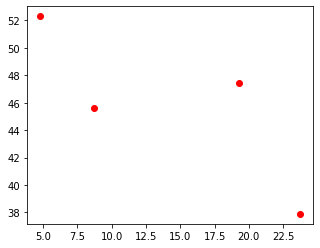

In [101]:
# creating the geopandas dataframe 
gdf = geopandas.GeoDataFrame(
    DF, geometry=geopandas.points_from_xy(DF.Longitude, DF.Latitude))
gdf.head()
gdf.plot(color='red')

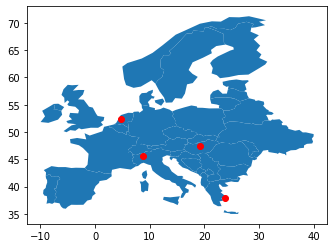

In [102]:
# plotting the coordinates on a map 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Europe.
eu = world[world.continent == 'Europe']

#Remove Russia and Iceland from map of Europe
eu=eu[(eu.name!='Russia') & (eu.name!='Iceland')]
#eu.plot()

# Create a custom polygon to remove French Guinea from map
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

#Clip polygon from the map of Europe
europe=geopandas.clip(eu, polygon) 

fig,ax=plt.subplots()
ax=europe.plot(ax=ax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

# !!!!! points are a bit out of place 

In [104]:
# calculating great circle distance between airports

# geopy uses latlon configuration
DF['latlon'] = list(zip(DF['Latitude'], DF['Longitude']))
square = pd.DataFrame(
    np.zeros((DF.shape[0], DF.shape[0])),
    index=DF.index, columns=DF.index
)

# defining the distance function: returns distance between a point and all the others in the network 
def get_distance(col):
    end = DF.loc[col.name, 'latlon']
    return DF['latlon'].apply(great_circle,
                              args=(end,)
                             )

distances = square.apply(get_distance, axis=1).T
distances = distances.rename(columns={0: 'MXP',1:'AMS', 2:'BUD', 3:'HEW'}, index={0: 'MXP',1:'AMS', 2:'BUD', 3:'HEW'})
distances

,MXP,AMS,BUD,HEW
MXP,0.0 km,796.6436042587967 km,829.508105018621 km,1508.5584877324336 km
AMS,796.6436042587964 km,0.0 km,1169.2131984337902 km,2174.182012019482 km
BUD,829.5081050186212 km,1169.2131984337905 km,0.0 km,1120.9989629485551 km
HEW,1508.5584877324338 km,2174.182012019482 km,1120.9989629485544 km,0.0 km


In [85]:
distances['AMS']['MXP']

Distance(796.6436042587967)

In [7]:
# 1: CREATING THE LIST OF AIRPORTS USING IATA CODES
Airports = DF['IATA code']

# 2: GENERATING ALL POSSIBLE COMBINATIONS OF AIRPORTS TO OBTAIN FLIGHT LEGS
F = list(itertools.combinations(Airports, 2))
print(F)

# 3: GENERATING ALL POSSIBLE ITINERARIES :

# CREATING A FUNCTION THAT GENERATES ALL POSSIBLE ITINERARIES FROM A LIST OF FLIGHT LEGS (TAKES F AS INPUT) 
def create_itineraries(F):
#set of non stop itineraries
    non_stop = [] 
    for f in F: 
        i = (f[0], '-', f[1])
        non_stop.append(i)

# set of one-stop itineraries 
    F1 = F
    one_stop = []
    for f in F: 
        for t in F1:
             if f[1]==t[0]:
                i = (f[0], f[1], t[1])
                one_stop.append(i)
   
#set of all itineraries 
    I = non_stop + one_stop
    #print(I)
    return I

# APPLYING THE FUNCTION
create_itineraries(F)

[('MXP', 'AMS'), ('MXP', 'BUD'), ('MXP', 'HEW'), ('AMS', 'BUD'), ('AMS', 'HEW'), ('BUD', 'HEW')]


[('MXP', '-', 'AMS'),
 ('MXP', '-', 'BUD'),
 ('MXP', '-', 'HEW'),
 ('AMS', '-', 'BUD'),
 ('AMS', '-', 'HEW'),
 ('BUD', '-', 'HEW'),
 ('MXP', 'AMS', 'BUD'),
 ('MXP', 'AMS', 'HEW'),
 ('MXP', 'BUD', 'HEW'),
 ('AMS', 'BUD', 'HEW')]

### Calculating pollution for each flight leg (think:how would the itinerary take it up then?) 

#### Fuel consumption regressions for chosen aircraft models: (Table M.7)
- E170: F = 7.15e−5d^2gc + 1.79dgc + 746
- A319: F = 7.70e−5d^2gc + 2.32dgc + 1280
- A321: F = −5.88e−5d^2gc + 4.09dgc + 1182

In [49]:
# Creating a dictionary that contains values for Distance where each key is a combination of Flight leg + Aircraft
D = {}
for flight_leg in F: 
    for aircraft in A: 
        D[flight_leg, aircraft] = distances[flight_leg[0]][flight_leg[1]]
    #print(distances[flight_leg[0]][flight_leg[1]])
D

{(('MXP', 'AMS'), 'E170'): Distance(796.6436042587964),
 (('MXP', 'AMS'), 'A319'): Distance(796.6436042587964),
 (('MXP', 'AMS'), 'A321'): Distance(796.6436042587964),
 (('MXP', 'BUD'), 'E170'): Distance(829.5081050186212),
 (('MXP', 'BUD'), 'A319'): Distance(829.5081050186212),
 (('MXP', 'BUD'), 'A321'): Distance(829.5081050186212),
 (('MXP', 'HEW'), 'E170'): Distance(1508.5584877324338),
 (('MXP', 'HEW'), 'A319'): Distance(1508.5584877324338),
 (('MXP', 'HEW'), 'A321'): Distance(1508.5584877324338),
 (('AMS', 'BUD'), 'E170'): Distance(1169.2131984337905),
 (('AMS', 'BUD'), 'A319'): Distance(1169.2131984337905),
 (('AMS', 'BUD'), 'A321'): Distance(1169.2131984337905),
 (('AMS', 'HEW'), 'E170'): Distance(2174.182012019482),
 (('AMS', 'HEW'), 'A319'): Distance(2174.182012019482),
 (('AMS', 'HEW'), 'A321'): Distance(2174.182012019482),
 (('BUD', 'HEW'), 'E170'): Distance(1120.9989629485544),
 (('BUD', 'HEW'), 'A319'): Distance(1120.9989629485544),
 (('BUD', 'HEW'), 'A321'): Distance(1120

In [126]:
dist_FA['Distance']+dist_FA['Distance']*3

SyntaxError: invalid syntax (4167740155.py, line 1)

In [50]:
# Creating a pandas dataframe from the newly created dictionary 
dist_FA = pd.DataFrame(list(D.items()))
dist_FA = dist_FA.rename(columns={0: 'Flight-leg + Aircraft type',1:'Distance'})
dist_FA

,Flight-leg + Aircraft type,Distance
0,"((MXP, AMS), E170)",796.6436042587964 km
1,"((MXP, AMS), A319)",796.6436042587964 km
2,"((MXP, AMS), A321)",796.6436042587964 km
3,"((MXP, BUD), E170)",829.5081050186212 km
4,"((MXP, BUD), A319)",829.5081050186212 km
5,"((MXP, BUD), A321)",829.5081050186212 km
6,"((MXP, HEW), E170)",1508.5584877324338 km
7,"((MXP, HEW), A319)",1508.5584877324338 km
8,"((MXP, HEW), A321)",1508.5584877324338 km
9,"((AMS, BUD), E170)",1169.2131984337905 km


In [106]:
Pollution = {}
for flight_leg in F: 
    for aircraft in A: 
        dist = distances[flight_leg[0]][flight_leg[1]]
        if aircraft == 'E170':
            Pollution[flight_leg, aircraft] = (dist**2)*7.15e-7+dist*1.79+746
        elif aicraft =='A319':
            Pollution[flight_leg, aircraft] = (dist**2)*7.70e-5+dist*2.32+1280
        else:
            Pollution[flight_leg, aircraft] = (dist**2)*(-5.88e-5)+dist*4.09+1182
Pollution 
    

TypeError: unsupported operand type(s) for ** or pow(): 'great_circle' and 'int'

In [127]:
Pollution = {} # remember to multiply * 3.16 
for flight_leg in F: 
    for aircraft in A: 
        dist = distances[flight_leg[0]][flight_leg[1]]
        if aircraft == 'E170':
            Pollution[flight_leg, aircraft] = dist*7.15e-7
        elif aircraft =='A319':
            Pollution[flight_leg, aircraft] = dist*7.70e-5
        else:
            Pollution[flight_leg, aircraft] = dist*-5.88e-5
Pollution 
    

{(('MXP', 'AMS'), 'E170'): Distance(0.0005696001770450394),
 (('MXP', 'AMS'), 'A319'): Distance(0.06134155752792732),
 (('MXP', 'AMS'), 'A321'): Distance(-0.046842643930417226),
 (('MXP', 'BUD'), 'E170'): Distance(0.0005930982950883142),
 (('MXP', 'BUD'), 'A319'): Distance(0.06387212408643383),
 (('MXP', 'BUD'), 'A321'): Distance(-0.04877507657509493),
 (('MXP', 'HEW'), 'E170'): Distance(0.0010786193187286902),
 (('MXP', 'HEW'), 'A319'): Distance(0.1161590035553974),
 (('MXP', 'HEW'), 'A321'): Distance(-0.0887032390786671),
 (('AMS', 'BUD'), 'E170'): Distance(0.0008359874368801603),
 (('AMS', 'BUD'), 'A319'): Distance(0.09002941627940186),
 (('AMS', 'BUD'), 'A321'): Distance(-0.06874973606790688),
 (('AMS', 'HEW'), 'E170'): Distance(0.0015545401385939298),
 (('AMS', 'HEW'), 'A319'): Distance(0.16741201492550012),
 (('AMS', 'HEW'), 'A321'): Distance(-0.12784190230674555),
 (('BUD', 'HEW'), 'E170'): Distance(0.0008015142585082165),
 (('BUD', 'HEW'), 'A319'): Distance(0.08631692014703869)

In [ ]:
import math

def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
        
    # Compute spherical distance from spherical coordinates.
        
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

In [38]:
Prova = []
for values in D.values():
    trial = values*100
    Prova.append(trial)
    
Prova

[Distance(79664.36042587964),
 Distance(82950.81050186213),
 Distance(150855.84877324337),
 Distance(116921.31984337905),
 Distance(217418.2012019482),
 Distance(112099.89629485544)]